In [1]:
import numpy as np

In [2]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
# import seaborn as sns
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '')
from train import fit
from sklearn.datasets import load_breast_cancer


class Neural_network:
    
    def __init__(self, nn_architecture,seed=2019):
        self.nn_architecture = nn_architecture
        self.params_values = {}
        np.random.seed(seed)
        for layer_idx_prev, layer in enumerate(nn_architecture):
            layer_idx_curr = layer_idx_prev+1
            input_dim = layer['input_dim']
            output_dim = layer['output_dim']
            self.params_values[f'W_{layer_idx_curr}'] = np.random.randn(output_dim,input_dim)*0.1
            self.params_values[f'b_{layer_idx_curr}'] = np.zeros([output_dim,1])
    
    def __sigmoid(self,Z_curr):
        A_curr = 1/(1+np.exp(-Z_curr))
        return A_curr
    
    def __ReLU(self, Z_curr):
        A_curr = np.maximum(0, Z_curr)
        return A_curr
    
    def __sigmoid_backward(self, dA_curr, Z_curr):
        A_curr = self.__sigmoid(Z_curr)
        dZ_curr = dA_curr*A_curr*(1-A_curr)
        return dZ_curr
    
    def __ReLU_backward(self, dA_curr, Z_curr):
        dZ_curr = np.array(dA_curr)
        dZ_curr[Z_curr<0]=0
        return dZ_curr
    
    def CrossEntropyLoss(self,y_hat, y):
        y_hat = np.array(y_hat)
        y = np.array(y)
        assert len(y_hat) == len(y)
        assert np.all(np.isin(np.unique(y),[0,1]))
        
        m = len(y)
        loss = 0
        mask_zeros = y==0
        loss += np.sum(np.log(1-y_hat[mask_zeros]+1e-15))
        mask_ones = y==1
        loss += np.sum(np.log(y_hat[mask_ones]+1e-15))
        return -1*loss/m
    
    def Accuracy(self, y_hat, y, threshold = 0.5):
        y_hat = np.array(y_hat)
        y = np.array(y)
        assert len(y_hat) == len(y)
        assert np.all(np.isin(np.unique(y),[0,1]))
        class_hat = y_hat>=threshold
        return np.mean(class_hat == y)
    
    def __single_layer_forward_propagation(self, W_curr, b_curr, A_prev, activation='relu'):
        Z_curr = W_curr@A_prev + b_curr
        
        if activation == 'relu':
            activation = self.__ReLU
        elif activation == 'sigmoid':
            activation = self.__sigmoid
        else:
            return Exception('Non-supported activation function')
        
        A_curr = activation(Z_curr)
        return A_curr, Z_curr
    
    def __fully_forward_propogation(self, X, params_values, nn_architecture):
        A_curr = X
        memory = {}
        
        for layer_idx_prev, layer in enumerate(nn_architecture):
            layer_idx_curr = layer_idx_prev+1
            activation = layer['activation']
            A_prev = A_curr
            W_curr = params_values[f'W_{layer_idx_curr}']
            b_curr = params_values[f'b_{layer_idx_curr}']
            A_curr, Z_curr = self.__single_layer_forward_propagation(W_curr, b_curr, A_prev, activation)
            memory[f'A_{layer_idx_prev}'] = A_prev
            memory[f'Z_{layer_idx_curr}'] = Z_curr
        return A_curr, memory
    
    def __single_layer_backward_propagation(self, dA_curr, A_prev, W_curr, Z_curr, activation = 'relu'):
        m = A_prev.shape[1]
        
        if activation == 'relu':
            activation_func = self.__ReLU_backward
        elif activation == 'sigmoid':
            activation_func = self.__sigmoid_backward
        else:
            return Exception('Non-supported activation function')
        
        dZ_curr = activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T)/m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True)/m
        dA_prev = np.dot(W_curr.T, dZ_curr)
        return dW_curr, db_curr, dA_prev
    
    def __fully_backward_propagation(self, y_hat, y, params_values, memory, nn_architecture):
        y_hat = np.array(y_hat)
        y = np.array(y)
        grads_values = {}
        
        dA_prev = -y/(y_hat+1e-15)+(1-y)/(1-y_hat+1e-15)
        for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
            layer_idx_curr=layer_idx_prev+1
            activation = layer['activation']
            dA_curr = dA_prev
            A_prev = memory[f'A_{layer_idx_prev}']
            W_curr = params_values[f'W_{layer_idx_curr}']
            Z_curr = memory[f'Z_{layer_idx_curr}']
            dW_curr, db_curr, dA_prev = self.__single_layer_backward_propagation(dA_curr, A_prev, W_curr, 
                                                                            Z_curr, activation)
            grads_values[f'dW_{layer_idx_curr}'] = dW_curr
            grads_values[f'db_{layer_idx_curr}'] = db_curr
        return grads_values
    
    def __updates(self, params_values, grads_values, nn_architecture, learning_rate):
        for layer_idx_prev, layer in enumerate(nn_architecture):
            layer_idx_curr = layer_idx_prev+1
            params_values[f'W_{layer_idx_curr}'] -= learning_rate*grads_values[f'dW_{layer_idx_curr}']
            params_values[f'b_{layer_idx_curr}'] -= learning_rate*grads_values[f'db_{layer_idx_curr}']
        return params_values
    
    def fit(self, X, Y, epochs, learning_rate, standardize = True):
        self.loss_history = []
        self.accuracy_history = []
        
        if Y.shape[0] != 1:
            Y = Y[None]
        
        if standardize:
            sample_mean = np.mean(X, axis=1)
            sample_mean = sample_mean[:,None]
            sample_std = np.std(X,axis=1)
            sample_std = sample_std[:,None]
            X = (X - sample_mean)/sample_std
        
        for _ in range(epochs):
            y_hat, cache = self.__fully_forward_propogation(X, self.params_values, self.nn_architecture)
            loss = self.CrossEntropyLoss(y_hat, Y)
            self.loss_history.append(loss)
            accuracy = self.Accuracy(y_hat, Y)
            self.accuracy_history.append(accuracy)
            
            grads_values = self.__fully_backward_propagation(y_hat, Y, self.params_values, cache, self.nn_architecture)
            self.params_values = self.__updates(self.params_values, grads_values,
                                                self.nn_architecture,learning_rate)
    
    def predict(self, X):
        prediction, _ = self.__fully_forward_propogation(X, self.params_values, self.nn_architecture)
        return prediction

In [3]:
data = load_breast_cancer()
x = data['data']
y = data['target']
x = x.reshape([30,569])

nn_architecture = [
    {"input_dim": x.shape[0], "output_dim": 10, "activation": "relu"},
    {"input_dim": 10, "output_dim": 1, "activation": "sigmoid"},
]
epochs = 20000

In [4]:
nn = Neural_network(nn_architecture,2019)

In [5]:
nn.fit(x,y,epochs=epochs,learning_rate=0.01)

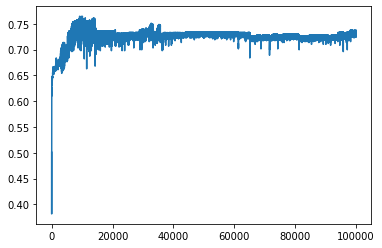

In [6]:
plt.plot(list(range(epochs)),nn.accuracy_history)